Fitting 3 folds for each of 243 candidates, totalling 729 fits


c:\Users\kally\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Train Accuracy: 0.9994505925751511
Test Accuracy: 0.9934086629001884
     mean_test_score  std_test_score  \
0           0.984695        0.000769   
1           0.983832        0.000800   
2           0.985009        0.000800   
3           0.986343        0.001169   
4           0.986186        0.001110   
..               ...             ...   
238         0.992701        0.000881   
239         0.993015        0.001059   
240         0.992936        0.000693   
241         0.992936        0.001154   
242         0.993015        0.000800   

                                                params  
0    {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
1    {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
2    {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
3    {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
4    {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
..                                                 ...  
238  {'colsample_bytree': 0.9, 'learning_rate': 0.2

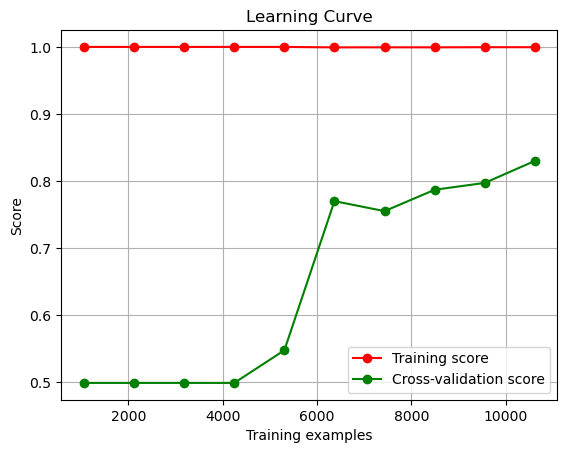

Accuracy: 0.9934086629001884
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1589
           1       0.99      0.99      0.99      1597

    accuracy                           0.99      3186
   macro avg       0.99      0.99      0.99      3186
weighted avg       0.99      0.99      0.99      3186



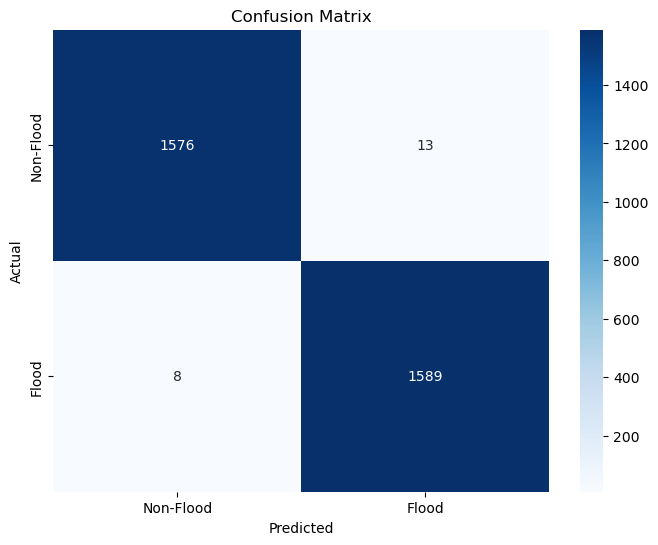

c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kally\anacond

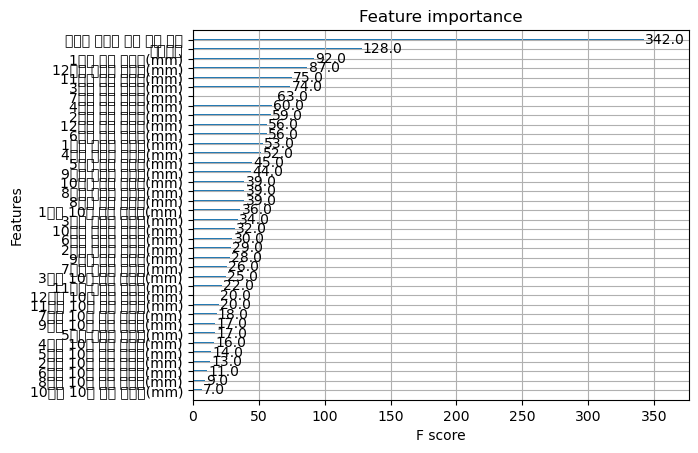

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 로드 및 전처리
non_flood_data_path = '침수가아닌날데이터.csv'
flood_data_path = '침수학습데이터.csv'

non_flood_data = pd.read_csv(non_flood_data_path)
flood_data = pd.read_csv(flood_data_path)

non_flood_data['target'] = 0
flood_data['target'] = 1

combined_data = pd.concat([non_flood_data, flood_data], ignore_index=True)

selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]

X = combined_data[selected_columns]
y = combined_data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 하이퍼파라미터 범위 설정
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300]
}

# XGBoost 분류기 초기화
xgb_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# GridSearchCV 초기화
grid_search = GridSearchCV(
    estimator=xgb_model, 
    param_grid=param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

# GridSearchCV 수행
grid_search.fit(X_train, y_train)

# 훈련 데이터와 테스트 데이터의 성능 비교
train_accuracy = accuracy_score(y_train, grid_search.predict(X_train))
test_accuracy = accuracy_score(y_test, grid_search.predict(X_test))

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

# 교차 검증 결과 확인
cv_results = pd.DataFrame(grid_search.cv_results_)
print(cv_results[['mean_test_score', 'std_test_score', 'params']])

# 최적의 하이퍼파라미터와 성능
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-validation Accuracy:", grid_search.best_score_)

# 학습 곡선 (Learning Curve)
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model.set_params(**grid_search.best_params_), 
    X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.show()

# 최적의 모델로 테스트 데이터 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# Confusion Matrix 시각화
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Flood', 'Flood'], yticklabels=['Non-Flood', 'Flood'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 피처 중요도 시각화
xgb.plot_importance(best_model)
plt.show()




#사용된 데이터 칼럼 
selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]



배수정보 : 배수 수준을 나타내는 척도입니다. 
XGBoost를 Decision Tree를 학습시키는 것이라고 생각해서 변수가 많은 것이 분할 조건을 많이 주는 것과 같다고 생각했습니다. 
그래서 기존 서울시에서 제공한 침수흔적도와 AWS 시간별 관측 데이터를 통해서 n시간 누적 강수량 / n시간동안의 10분당 평균 강수량 / n시간동안의 시간당 평균 강수량
이렇게 데이터 칼럼을 추가해 넣었습니다. 
그리고 2022년의 날 중 침수가 되지 않은 날짜를 랜덤으로 뽑은 뒤에 똑같은 방식으로 강수량 관련 칼럼을 추가해 넣었습니다. 

학습 결과가 오버피팅이 예상이 되는데 , 지금 추정되는 이유로는 침수가 되지 않고, 비가 많이 안오는 날이 1년 365일중 대부분이라서 
침수가 된 날과 침수가 되지 않은 날의 데이터의 차이가 크기 때문이라는 생각이 듭니다.